<style>
    div.output_wrapper {
      line-height: 1em; padding: 0;
      font-size: 1.2em;
    }
</style>


# Demonstration Informed Specification Search: Experiment

Let's take a look at how the DISS algorithm can search for specifications by leveraging expert demonstrations. 
We'll focus on learning DFAs in this case, but note that this approach is not confined to any specific concept class. To start consider an agent operating in the following stochastic gridworld.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_1.svg"
         style="height: 25em;"
     />
</figure>

## Agent Actions

The agent can attempt to move up, down, left, or right as illustrated below.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_2.svg"
         style="height: 20em;"
     />
</figure>

## Stochastic Transitions

However, there is some small probability that the agent will slip downward do to wind!

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_3.svg"
         style="height: 20em;"
     />
</figure>



Let's assume the agent's task can be described in terms of the color's of the tiles. **What was the agent trying to do?**


## Probably avoiding the red tiles

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_4.svg"
         style="height: 20em;"
     />
</figure>

## Probably trying to reach yellow tile

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_5.svg"
         style="height: 20em;"
     />
</figure>

In this notebook, we will illustrate learning task representations (in the form of Deterministic Finite Automata, i.e. DFA) that can be learned incrementally and describe temporal tasks.

In particular, we shall consider a variation of the following gridworld from [this](https://mjvc.me/DISS/#/77) slide deck: Here the agent's task is a composition of three subtasks.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_1.svg"
         style="height: 20em;"
     />
</figure>

Where each subtask is a regular language represented as a DFA.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_2_1.svg"
         style="height: 20em;"
     />
</figure>

Further, we shall assume that the first two subtasks are a-priori known (say due to learning in another workspace), 
<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_1_2.svg"
         style="height: 20em;"
     />
</figure>

and our task is to learn the third task given a partial demonstration.
<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_3_2.svg"
         style="height: 20em;"
     />
</figure>


# Preamble

In [1]:
from functools import lru_cache

import attr
import funcy as fn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bidict import bidict
from IPython.display import Image, display, SVG
import networkx as nx
import pydot

from collections import Counter

import dfa
from dfa.utils import find_subset_counterexample, find_equiv_counterexample
from dfa_identify import find_dfa, find_dfas

from diss.product_mc import ProductMC
from diss.dfa_concept import DFAConcept
from diss.domains.gridworld_naive import GridWorldNaive as World
from diss.domains.gridworld_naive import GridWorldState as State
from diss import search, LabeledExamples, GradientGuidedSampler, ConceptIdException
from pprint import pprint
from itertools import combinations
from tqdm import tqdm_notebook
from tqdm.notebook import trange
from IPython.display import clear_output
from IPython.display import HTML as html_print
from functools import reduce

sns.set_context('notebook')
sns.set_style('darkgrid')

## Let's first visualize our gridworld and a demonstration within the gridworld.

In [2]:
COLOR_ALIAS = {
    'white': 'white',
    'yellow': '#ffff00', 
    #'brown': '#ffb081',
    'red': '#ff8b8b',
    'blue': '#afafff', 
    'green' : '#8ff45d'
}


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def ap_at_state(x, y, world):
    """Use sensor to create colored tile."""
    if (x, y) in world.overlay:
        color = world.overlay[(x,y)]

        if color in COLOR_ALIAS.keys():
            return tile(color)
    return tile('white')

def print_map(world):
    """Scan the board row by row and print colored tiles."""
    order = range(1, world.dim + 1)
    buffer = ''
    for y in order:
        chars = (ap_at_state(x, y, world) for x in order)
        buffer += '&nbsp;'.join(chars) + '<br>'
    display(html_print(buffer))

def print_trc(trc, world, idx=0):
    states = [s for s, kind in trc if kind == 'ego']
    actions = [s.action for s, kind in trc if kind == 'env']

    obs = [ap_at_state(pos.x, pos.y, world) for pos in states]
    display(
        html_print(f'trc {idx}:&nbsp;&nbsp;&nbsp;' + ''.join(''.join(x) for x in zip(obs, actions)) + '\n')
    ) 

In [3]:
gw = World(
    dim=3,
    start=State(x=3, y=1),
    overlay={
      (1, 1): 'yellow',
      (1, 2): 'green',
      (1, 3): 'green',
      (2, 3): 'red',
      (3, 2): 'blue',
      (3, 3): 'blue',
    }
)

demos = [[
   (State(3, 1), 'ego'),
   (State(3, 1, '←'), 'env'),
   (State(3, 2), 'ego'),
   (State(3, 2, '←'), 'env'),
   (State(2, 2), 'ego'),
   (State(2, 2, '←'), 'env'),
   (State(1, 2), 'ego'),
   (State(1, 2, '↑'), 'env'),
   (State(1, 1), 'ego'),
]]

print_map(gw)
print_trc(demos[0], gw)

Compare against our target domain:

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_3_2.svg"
         style="height: 20em;"
     />
</figure>

# Search procedure

Now, we can define a set of expert demonstrations for this gridworld to guide our specification search procedure.

Let's start with some very simple base examples to warm-start our specification search process. We want to synthesize a spec that's consistent with the observed evidence thus far:

Going from the partial spec to a full spec :

In [4]:
def partial_dfa(inputs):
    def transition(s, c):
        if c == 'red':
            return s | 0b01
        elif c == 'yellow':
            return s | 0b10
        return s

    return dfa.DFA(
        start=0b00,
        inputs=inputs,
        label=lambda s: s == 0b10,
        transition=transition
    )

def ignore_white(path):
    return tuple(x for x in path if x != 'white')

Now, we can outline the machinery for the search process itself. We use the solution procedure in the DFA identification algorithm to synthesize a minimal DFA (in both states and non-stuttering edges) that is consistent with the observed examples to this point. 

In [5]:
@fn.memoize(key_func=lambda accepting, rejecting, alphabet, order_by_stutter: hash((accepting, rejecting)))
def find_dfas2(accepting, rejecting, alphabet, order_by_stutter):
    dfas = find_dfas(accepting, rejecting, alphabet=alphabet, order_by_stutter=order_by_stutter)
    dfas = fn.take(10, dfas)
    return dfas

In [6]:
def subset_check_wrapper(dfa_candidate):
    partial = partial_dfa(dfa_candidate.inputs)
    ce = find_subset_counterexample(dfa_candidate, partial)
    return ce is None


ALPHABET = frozenset({'red', 'yellow', 'blue', 'green'})

base_examples = LabeledExamples(
    positive=[
        ('yellow',),
        ('yellow', 'yellow'),
    ],
    negative=[
        (), ('red',), ('red', 'red'),
        ('red', 'yellow'), ('yellow', 'red'),
        ('yellow', 'red', 'yellow'),
        ('yellow', 'yellow', 'red'),
    ]
)


@fn.memoize
def subset_cegis(data):
    global base_examples

    for i in range(20):
        mydfa = find_dfa(data.positive, data.negative, order_by_stutter=True) 
        if mydfa is None:
            raise ConceptIdException
        partial = partial_dfa(mydfa.inputs)
        ce = find_subset_counterexample(mydfa, partial)
        if ce is None:
            break
        base_examples @= LabeledExamples(negative=[ce])
        data @= LabeledExamples(negative=[ce])

        for k, lbl in enumerate(partial.transduce(ce)):
            prefix = ce[:k]
            if not lbl:
                base_examples @= LabeledExamples(negative=[prefix])
                data @= LabeledExamples(negative=[prefix])
    return data


def to_concept(data):
    global base_examples
    
    data = data.map(ignore_white) @ base_examples
    data = subset_cegis(data)

    concept = DFAConcept.from_examples(
        data, subset_check_wrapper, alphabet=ALPHABET,
        find_dfas=find_dfas2, temp=1/4) 
    # Adjust size to account for subset information.
    return attr.evolve(concept, size=concept.size - np.log(3))

In [7]:
from diss.dfa_concept import remove_stutter
from collections import defaultdict

# adapted from the dfa library
def get_dot(dfa_):
    dfa_dict, init = dfa.dfa2dict(dfa_)
    remove_stutter(dfa_dict)
    g = pydot.Dot(rankdir="LR")

    nodes = {}
    for i, (k, (v, _)) in enumerate(dfa_dict.items()):
        shape = "doublecircle" if v else "circle"
        nodes[k] = pydot.Node(i+1, label=f"{k}", shape=shape, color="white", fontcolor="white")
        g.add_node(nodes[k])

    edges = defaultdict(list)
    for start, (_, transitions) in dfa_dict.items():        
        for action, end in transitions.items():
            color = COLOR_ALIAS[str(action)]
            edges[start, end].append(color)
    
    init_node = pydot.Node(0, shape="point", label="", color="white")
    g.add_node(init_node)
    g.add_edge(pydot.Edge(init_node, nodes[init], color="white"))

    for (start, end), colors in edges.items():
        #color_list = f':'.join(colors)
        #g.add_edge(pydot.Edge(nodes[start], nodes[end], color=color_list))
        for color in colors:
            g.add_edge(pydot.Edge(nodes[start], nodes[end], label='◼', fontcolor=color, color="white"))
    g.set_bgcolor("#002b36")        
    return g

def view_pydot(pdot):
    plt = SVG(pdot.create_svg())
    #plt = Image(pdot.create_png())
    display(plt)

# Simulated Annealed + SGGS

In [8]:
from diss import diss

In [9]:
@fn.memoize(key_func=lambda c, t, psat: c.dfa)
def to_chain(c, t, psat):
    chain = ProductMC.construct(
        concept=c, tree=t, dyn=gw, max_depth=9,
        psat=0.8, sensor=gw.sensor, xtol=0.05
    )
    return chain

In [10]:
n_iters = 50

dfa_search = diss(
    demos=demos,
    to_concept=to_concept,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lambda x: ignore_white(map(gw.sensor, x)),
    n_iters=n_iters,
    reset_period=5,
    surprise_weight=20,  # Rescale surprise to make comparable to size.
    cmf_threshold=0.99,
)

concept2energy = {}
for _, (data, concept, metadata) in zip(trange(n_iters, desc='DISS'), dfa_search):
    concept2energy[concept] = metadata['energy']
    poi = metadata['poi']
    #view_pydot(get_dot(concept.dfa))

DISS:   0%|          | 0/50 [00:00<?, ?it/s]

Z=4.802845146864312e-10
prob = 0.189
energy = 23.1
size = 0.693


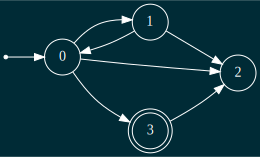

prob = 0.162
energy = 23.3
size = 0.847


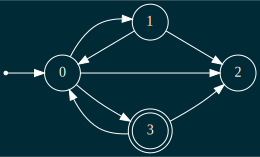

prob = 0.162
energy = 23.3
size = 0.847


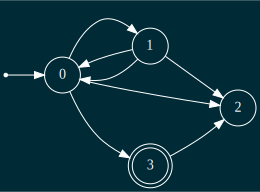

prob = 0.162
energy = 23.3
size = 0.847


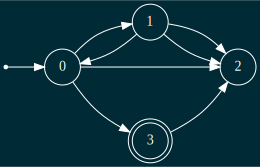

prob = 0.162
energy = 23.3
size = 0.847


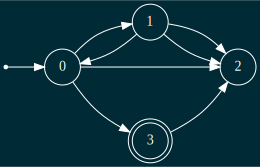

prob = 0.162
energy = 23.3
size = 0.847


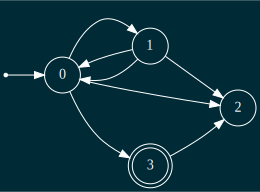

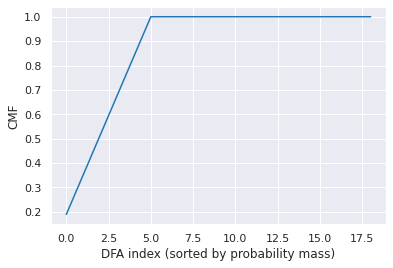

In [11]:
sorted_concepts = sorted(list(concept2energy), key=concept2energy.get)
pmf = np.array([np.exp(-concept2energy[c]) for c in sorted_concepts])
Z = pmf.sum()
print(f'{Z=}')
pmf /= Z
cmf = np.cumsum(pmf)
idx = (cmf < 0.99).sum()  # 99% of probability mass concentrated below this point.

for p, c in zip(pmf, sorted_concepts[:idx + 1]):
    print(f'prob = {p:.3}')
    print(f'energy = {concept2energy[c]:.3}')
    print(f'size = {c.size:.3}')
    view_pydot(get_dot(c.dfa))

# Plot CDF of distribution.
sns.lineplot(x=list(range(len(cmf))), y=cmf)
plt.xlabel('DFA index (sorted by probability mass)')
plt.ylabel('CMF')
plt.show()

In [12]:
# 4. Compute current support's belief on unlabeled strings of interest.
p_accept = {}
for word in poi:
    votes = np.array([(word in c) for c in sorted_concepts])
    p_accept[word] = pmf @ votes
    
sorted_poi = sorted(poi, key=lambda x: -p_accept[x])

buff = ''
for word in sorted_poi:
    obs = '\n'.join(map(tile, word))
    buff += f'{p_accept[word]:.2}:'.ljust(9, 'X').replace('X', '&nbsp')
    buff += f'{obs}<br>'
display(html_print(buff))

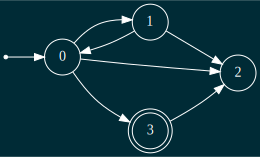

In [13]:
accepting, rejecting = set(), set()
for word in poi:
    belief = p_accept[word]
    if belief > 0.9:
        accepting.add(word)
    elif belief < 0.1:
        rejecting.add(word)
data = LabeledExamples(accepting, rejecting)
view_pydot(get_dot(to_concept(data).dfa))

# Enumeration baseline

In [14]:
def sampler_factory(demos):
    return GradientGuidedSampler.from_demos(
        demos=demos,
        to_chain=to_chain,
        competency=lambda *_: 0.8,
    )

In [15]:
to_chain.invalidate_all()

In [16]:
from dfa.utils import minimize

def enumerate_dfas():
    data = LabeledExamples(
        positive=[
            ('yellow',),
            ('yellow', 'yellow'),
        ],
        negative=[
            (), ('red',), ('red', 'red'),
            ('red', 'yellow'), ('yellow', 'red'),
            ('yellow', 'red', 'yellow'),
            ('yellow', 'yellow', 'red'),
        ]
    )

    # CEGIS loop to add constraints to enforce subsets.
    for i in range(20):
        tests = fn.take(5, find_dfas(
            data.positive,
            data.negative,
            order_by_stutter=True,
            allow_unminimized=True,
        ))
        new_data = LabeledExamples()
        for test in tests:
            assert test is not None
            partial = partial_dfa(test.inputs)
            ce = find_subset_counterexample(test, partial)
            if ce is not None:
                new_data @= LabeledExamples(negative=[ce])
        if new_data.size == 0:
            break

    dfas = find_dfas(
        data.positive,
        data.negative,
        order_by_stutter=False,
        alphabet=ALPHABET,
        allow_unminimized=True,
    )

    yield from map(minimize, filter(subset_check_wrapper, dfas))


In [17]:
sggs = sampler_factory(demos)

In [18]:
Z2 = 0
dist = Counter()
for i, d in enumerate(fn.distinct(enumerate_dfas())):
    concept = DFAConcept.from_dfa(d)
    dist.update([len(d.states())])
    print(dist)
    print(f'             {i}                ')
    energy = 20 * sggs(concept)[1]['surprisal'] + concept.size
    Z2 += np.exp(-energy)
    
    print(f'{energy=:.3}')
    print(f'Z2 / Z = {Z2 / Z:0.3}')
    print('--------------------------------')
    if i > 50:
        break
    #view_pydot(get_dot(d))

Counter({3: 1})
             0                
energy=72.7
Z2 / Z = 5.75e-23
--------------------------------
Counter({3: 2})
             1                
energy=37.2
Z2 / Z = 1.51e-07
--------------------------------
Counter({3: 3})
             2                
energy=37.8
Z2 / Z = 2.29e-07
--------------------------------
Counter({3: 4})
             3                
energy=38.8
Z2 / Z = 2.6e-07
--------------------------------
Counter({3: 5})
             4                
energy=98.3
Z2 / Z = 2.6e-07
--------------------------------
Counter({3: 6})
             5                
energy=98.3
Z2 / Z = 2.6e-07
--------------------------------
Counter({3: 7})
             6                
energy=98.2
Z2 / Z = 2.6e-07
--------------------------------
Counter({3: 8})
             7                
energy=1.02e+02
Z2 / Z = 2.6e-07
--------------------------------
Counter({3: 9})
             8                
energy=1.02e+02
Z2 / Z = 2.6e-07
--------------------------------
Counter(

# Circuit + BDD based MaxEnt Policy (CAV '20)

🚨 🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧 🚨

Everything after this point of the notebook is currently under development!

🚨 🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧 🚨 

# 1. Create Dynamical System

Here we create a BitVector sequential circuit, `DYN`, using `py-aiger`, the models a gridworld (line 4).

Afterwords, lines 6-8 describe introducing a slip probability of `1/32` (modeled by a biased coin with bias `31/32`). 

**Note that states are 1-hot encoded**

In [19]:
import aiger as A
import aiger_bv as BV
import aiger_gridworld as GW
import aiger_ptltl as LTL
from bidict import bidict
from aiger_bdd import to_bdd

In [20]:
STATE = BV.uatom(16, 'state')
X = STATE[:8]
Y = STATE[8:]
s0 = (3, 5)
#                            
DYN = GW.gridworld(8, start=(s0[0], 9 - s0[1]), compressed_inputs=True)
SLIP = BV.atom(1, 'c', signed=False).repeat(2) & BV.atom(2, 'a', signed=False)
SLIP = SLIP.with_output('a').aigbv
DYN <<= SLIP

def encode_state(x, y):
    x, y = x - 1, (9 - y) + 7
    return {'state': (1 << x) | (1 << y)}

# 2. Create Sensor / Feature overlay

Next, we define the mapping from concrete states to sensor values / atomic predicates.
We use simple coordinate wise bitvector masks to encode the color overlays.

In [21]:
def mask_test(xmask, ymask):
    return ((X & xmask) !=0) & ((Y & ymask) != 0)


APS = {       #            x-axis       y-axis
    'yellow': mask_test(0b0000_0001, 0b1000_0001),
    'blue':   mask_test(0b0000_1010, 0b0011_1100),
    'green':  mask_test(0b0010_0000, 0b1000_0000),
    'red':    mask_test(0b1000_0000, 0b0011_0010) \
            | mask_test(0b0011_1111, 0b0000_0010),
}

def create_sensor(aps):
    sensor = BV.aig2aigbv(A.empty())
    for name, ap in APS.items():
        sensor |= ap.with_output(name).aigbv
    aps = reduce(lambda x, y: x.concat(y), APS.values())
    sensor |= (aps == 0).with_output('white').aigbv
    return sensor

SENSOR = create_sensor(APS)

In [22]:
SENSOR.outputs

{'blue', 'green', 'red', 'white', 'yellow'}

## Visualizing Overlay

This can all seem pretty abstract, so let's visualize the way the sensor sees the board.

In [23]:
from IPython.display import HTML as html_print


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def ap_at_state(x, y, in_ascii=False):
    """Use sensor to create colored tile."""
    state = encode_state(x, y)
    obs = SENSOR(state)[0]   # <----------   
    for k in COLOR_ALIAS.keys():
        if k == 'brown':
            continue
        if obs[k][0]:
            return tile(k)
    raise NotImplementedError

def print_map():
    """Scan the board row by row and print colored tiles."""
    order = range(1, 9)
    buffer = ''
    for y in order:
        chars = (ap_at_state(x, y, in_ascii=True) for x in order)
        buffer += '&nbsp;'.join(chars) + '<br>'
    display(html_print(buffer))
    
DYN_SENSE = DYN >> SENSOR

def encode_trace(trc):
    actions, states = trc
    actions = [{'a': a} for a in actions]
    states = [encode_state(*s) for s in states]

    # Fill in coin flips to mark slipping. Could use SAT solver more generally.
    for s, a, s2 in zip([encode_state(*s0)] + states, actions, states):
        s, s2 = GW.GridState(s['state'], 8), GW.GridState(s2['state'], 8)
        action = a['a']
        print(s.x, s.y)
        print(s2.x, s2.y)

        if action == GW.WEST:
            a['c'] = 1
        elif action == GW.EAST:
            a['c'] = int((s2.x > s.x) or s.x == 8)
        else:
            a['c'] = int(s.x == s2.x)
    actions[-1]['c'] = 1  # Last action needs some arbitrary assignment to slipping.
    
    return actions, states


def lift_path(path):
    aps = fn.pluck(0, DYN_SENSE.simulate(path))
    aps = [fn.first(k for k, v in ap.items() if v == 1) for ap in aps]
    print(ignore_white(aps))
    return ignore_white(aps)


def print_trc(trc, idx=0):
    obs = lift_path(trc)
    actions = [x['a'] for x in trc]
    obs = map(tile, obs)
    display(
        html_print(f'trc {idx}:&nbsp;&nbsp;&nbsp;' + ''.join(''.join(x) for x in zip(actions, obs)) + '\n')
    )
        
print_map()

TRC4 = [
    {'a': '↑', 'c': 0},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},

]

print(len(TRC4))

print_trc(TRC4, 4)

14
('blue', 'blue', 'blue', 'green', 'yellow')


In [24]:
test_states = [{'state': x['state'].yx} for x, _ in DYN.simulate(TRC4)]

for s, _ in DYN.simulate(TRC4):
    print(s['state'].board)
    
test_colors = fn.lpluck(0, SENSOR.simulate(test_states))


8 □ □ □ □ □ □ □ □
7 □ □ □ □ □ □ □ □
6 □ □ □ □ □ □ □ □
5 □ □ □ □ □ □ □ □
4 □ ▪ □ □ □ □ □ □
3 □ □ □ □ □ □ □ □
2 □ □ □ □ □ □ □ □
1 □ □ □ □ □ □ □ □
  1 2 3 4 5 6 7 8


8 □ □ □ □ □ □ □ □
7 □ □ □ □ □ □ □ □
6 □ □ □ □ □ □ □ □
5 □ ▪ □ □ □ □ □ □
4 □ □ □ □ □ □ □ □
3 □ □ □ □ □ □ □ □
2 □ □ □ □ □ □ □ □
1 □ □ □ □ □ □ □ □
  1 2 3 4 5 6 7 8


8 □ □ □ □ □ □ □ □
7 □ □ □ □ □ □ □ □
6 □ ▪ □ □ □ □ □ □
5 □ □ □ □ □ □ □ □
4 □ □ □ □ □ □ □ □
3 □ □ □ □ □ □ □ □
2 □ □ □ □ □ □ □ □
1 □ □ □ □ □ □ □ □
  1 2 3 4 5 6 7 8


8 □ □ □ □ □ □ □ □
7 □ □ □ □ □ □ □ □
6 □ □ ▪ □ □ □ □ □
5 □ □ □ □ □ □ □ □
4 □ □ □ □ □ □ □ □
3 □ □ □ □ □ □ □ □
2 □ □ □ □ □ □ □ □
1 □ □ □ □ □ □ □ □
  1 2 3 4 5 6 7 8


8 □ □ □ □ □ □ □ □
7 □ □ ▪ □ □ □ □ □
6 □ □ □ □ □ □ □ □
5 □ □ □ □ □ □ □ □
4 □ □ □ □ □ □ □ □
3 □ □ □ □ □ □ □ □
2 □ □ □ □ □ □ □ □
1 □ □ □ □ □ □ □ □
  1 2 3 4 5 6 7 8


8 □ □ ▪ □ □ □ □ □
7 □ □ □ □ □ □ □ □
6 □ □ □ □ □ □ □ □
5 □ □ □ □ □ □ □ □
4 □ □ □ □ □ □ □ □
3 □ □ □ □ □ □ □ □
2 □ □ □ □ □ □ □ □
1 □ □ □ □ □ □ □ □
  1 2 3 4 5 6 7 8


8 □ □ □ ▪ □ □ □

# 4. Define Specification Circuits / Concept Class



In [25]:
import aiger_dfa

In [26]:
from dfa import DFA, dfa2dict, dict2dfa
from functools import reduce

def concept2monitor(concept):
    # Add noop on white:
    def transition_with_noop(s, c):
        if c == 'white':
            return s
        return concept.dfa._transition(s, c)
    
    dfa = DFA(
        start=concept.dfa.start,
        outputs=concept.dfa.outputs,
        inputs=COLOR_ALIAS,
        label=concept.dfa._label,
        transition=transition_with_noop,
    )
    dfa = attr.evolve(concept.dfa, transition=transition_with_noop, inputs=frozenset(COLOR_ALIAS))
    circ, relabels, _ = aiger_dfa.dfa2aig(dfa)
    # Wrap circ i/o to interface with sensor.
    atoms = [BV.uatom(1, c) for c in COLOR_ALIAS]

    # Convert input.
    def get_idx(atom):
        c = fn.first(atom.inputs)
        return relabels['inputs'][c]['action'].index(True)

    atoms = sorted(atoms, key=get_idx)
    action = reduce(lambda x, y: x.concat(y), atoms).with_output('action')
    
    # Convert output.
    output = BV.uatom(2, 'output')
    for key, val in relabels['outputs'].items():
        if val is True:
            sat = output[key['output'].index(True)].with_output('SAT')
    
    monitor = action.aigbv >> circ >> sat.aigbv
    monitor = attr.evolve(monitor, aig=monitor.aig.lazy_aig)  # HACK: force lazy evaluation.
    return DYN >> SENSOR >> monitor, relabels

# Creating BDD game-graph

In [27]:
H = 15  # SAT output only depends on latch....
causal_order = []
for t in range(H):
    causal_order.append(f'a##time_{t}[0]')
    causal_order.append(f'a##time_{t}[1]')
    causal_order.append(f'c##time_{t}[0]')
causal_order = {x: i for i, x in enumerate(causal_order)}

In [28]:
from dd.cudd import BDD

In [29]:
manager = BDD()
manager.declare(*causal_order)

In [30]:
import networkx as nx

In [31]:
def to_nx(bexpr):
    # DFS to translate edge-compelemented BDD to networkx graph.
    dag = nx.DiGraph()

    stack, visited = [(bexpr, False, int(bexpr))], set()
    while stack:
        bexpr, parity, ref = stack.pop()

        if ref in visited:
            continue

        visited.add(ref)
        if bexpr in (bexpr.bdd.true, bexpr.bdd.false):
            label = (bexpr == bexpr.bdd.true) ^ parity
            dag.add_node(ref, label=label, level=len(bexpr.bdd.vars))
            continue

        dag.add_node(ref, label=bexpr.var, level=bexpr.level)

        parity = bexpr.negated ^ parity
        for lbl, bexpr2 in [(0, bexpr.low), (1, bexpr.high)]:
            ref2 = int(bexpr2 if parity else ~bexpr2)
            dag.add_edge(ref, ref2, label=lbl)
            stack.append((bexpr2, parity, ref2))
            
    #TODO: Everything above this line should be upstreamed into aiger-bdd.
            
    for src, data in dag.nodes(data=True):
        label = data['label']
        if isinstance(label, bool):
            data['kind'] = label
        elif label.startswith('a'):
            data['kind'] = 'ego'
        else:
            data['kind'] = 'env'

    for src, tgt, data in dag.edges(data=True):
        entropy = dag.nodes[tgt]['level'] - dag.nodes[src]['level'] - 1
        entropy /= np.log2(np.e)  # Convert from base 2.
        data['entropy'] = entropy
    
        if dag.nodes[src]['kind'] == 'env':
            data['prob'] = 31/32 if data['label'] else 1/32
    return dag

# Create Tabular Policy from BDD

1. Create policy on BDD Game graph.
2. Lift bit level policy into policy over ego and env actions (at bitvectors)

In [32]:
from diss import DemoPrefixTree as PrefixTree

In [33]:
from diss.tabular import TabularPolicy

In [34]:
import dd.cudd

In [35]:
def to_demo(trc):
    demo = [(None, 'ego')]
    for circ_input in trc:
        demo.extend([
            (circ_input['a'], 'env'),
            (circ_input['c'], 'ego'),
        ])
    return demo

In [36]:
tree = PrefixTree.from_demos([to_demo(TRC4)])

In [37]:
#               bdd-id    lvl   prev action  
# Node = tuple[  int  ,   int,  int | str]   # Lifted policy state.

def get_lvl(dag, node):
    label = dag.nodes[node]['label']
    if isinstance(label, bool):
        return len(causal_order)
    return causal_order[label]

def get_debt(dag, node1, node2):
    lvl1 = get_lvl(dag, node1)
    lvl2 = get_lvl(dag, node2)
    return lvl2 - lvl1 - 1

def walk(dag, curr, bits):
    for bit in bits:
        yield curr
        node, debt = curr
        if debt > 0:  # Don't care consumes bits.
            curr = (node, debt - 1)
            continue
        # Use bit for BDD transition.
        if dag.out_degree(node) == 0:
            import pdb; pdb.set_trace()
        for kid in dag.neighbors(node):
            if bit == dag.edges[node, kid]['label']:
                break
        curr = (kid, get_debt(dag, node, kid))
    yield curr


@attr.frozen
class LiftedPolicy:
    policy: TabularPolicy

    def psat(self, node = None): return self.policy.psat(node[0])
    def lsat(self, node = None): return self.policy.lsat(node[0])
        
    @property
    def root(self):
        return (self.policy.root, 0, None)

    @staticmethod
    def from_psat(unrolled, psat, xtol=0.5):
        return LiftedPolicy(TabularPolicy.from_psat(unrolled, psat, xtol=xtol))

    def prob(self, node, move, log = False):
        dag = self.policy.dag
        node1, debt1, _ = node 
        node2, debt2, action = move
        assert (node1 != node2) or (debt1 > debt2 >= 0)

        if isinstance(action, int):
            prob = 31 / 32 if action else 1/32
            return np.log(prob) if log else prob

        action = GW.dynamics.ACTIONS_C[action]
        bits = [action & 1, (action >> 1) & 1]
        curr = (node1, debt1)
        edges = fn.pairwise(walk(dag, (node1, debt1), bits))
        
        logp = 0
        for start, end in edges:
            if start[0] == end[0]:  # Don't care consumes bits.
                logp -= np.log(2)
            else:
                logp += self.policy.prob(start[0], end[0], log=True)

        assert end == (node2, debt2)
        return logp if log else np.exp(logp)

    def transition(self, pstate, action):
        dag = self.policy.dag
        if isinstance(action, str):  # action correspond to previous action.
            bits = GW.dynamics.ACTIONS_C[action]
            bits = [bits & 1, (bits >> 1) & 1]
        else:
            bits = [action]
        node, debt = fn.last(walk(dag, pstate[:2], bits))  # QDD state.
        return (node, debt, action)

    def end_of_episode(self, pstate):
        node, debt, _ = pstate
        dag = self.policy.dag
        return (debt == 0) and (dag.out_degree(node) == 0)

In [38]:
import random

@attr.frozen
class CompressedMC:
    """Compressed Markov Chain operating with actions."""
    tree: PrefixTree
    policy: LiftedPolicy
    tree2policy: dict[int, tuple[int, int]]

    @property
    def edge_probs(self):
        edge_probs = {}
        for tree_edge in self.tree.tree.edges:
            dag_edge = [self.tree2policy[s] for s in tree_edge]
            edge_probs[tree_edge] = self.policy.prob(*dag_edge)
        return edge_probs

    def sample(self, pivot, win):
        policy = self.policy
        state = self.tree2policy[pivot]

        if policy.psat(state) == float(not win):
            return None  # Impossible to realize is_sat label.

        sample_prob: float = 1
        path = list(self.tree.prefix(pivot))
        if policy.end_of_episode(state):
             moves = []
        else:
            prev_ego = isinstance(state[-1], str)

            # Make sure to deviate from prefix tree at pivot.
            actions = {0, 1} if prev_ego else set(GW.dynamics.ACTIONS_C)
            actions -= {self.tree2policy[s][-1] for s in self.tree.tree.neighbors(pivot)}

            tmp = {policy.transition(state, a) for a in actions}

            moves = list(m for m in tmp if policy.psat(m) != float(not win))

        if not moves:
            return None  # Couldn't deviate
        
        # Sample suffix to path conditioned on win.
        while moves:
            # Apply bayes rule to get Pr(s' | is_sat, s).
            priors = np.array([policy.prob(state, m) for m in moves])
            likelihoods = np.array([policy.psat(m) for m in moves])
            normalizer = policy.psat(state)

            if not win:
                likelihoods = 1 - likelihoods
                normalizer = 1 - normalizer

            probs =  priors * likelihoods / normalizer
            prob, state = random.choices(list(zip(probs, moves)), probs)[0]
            sample_prob *= prob

            # Note: win/lose are strings so the below still works...
            action = state[-1]
            path.append(action)

            if policy.end_of_episode(state):
                moves = []
            else:
                prev_ego = isinstance(action, str)
                actions = {0, 1} if prev_ego else set(GW.dynamics.ACTIONS_C)
                moves = [policy.transition(state, a) for a in actions]

        return path, sample_prob
 
    @staticmethod
    def construct(concept, tree, psat):
        # 1. Compile concept: DFA -> AIG -> BDD -> Annotated DAG.
        monitor, _ = concept2monitor(concept)
        unrolled = monitor.aigbv.cone('SAT').unroll(H, only_last_outputs=True)
        manager = BDD()
        manager.declare(*causal_order)
        bexpr, *_ = to_bdd(unrolled, manager=manager, renamer=lambda _, x: x, levels=causal_order)
        dag = to_nx(bexpr)
        
        # 2. Fit (lifted) MaxEntPolicy.
        policy = LiftedPolicy.from_psat(dag, psat=psat)
        
        # 3. Need to associcate each tree stree with a policy state.
        stack = [(tree.root, policy.root)]
        tree2policy = {}
        while stack:
            tstate, pstate = stack.pop()
            tree2policy[tstate] = pstate

            # Compute local mapping from dynamics transition to next pstate.
            #move = {s[0]: s for s in policy.dag.neighbors(pstate)}
            for tstate2 in tree.tree.neighbors(tstate):
                action = tree.state(tstate2)  # tree states are next actions.
                pstate2 = policy.transition(pstate, action)
                stack.append((tstate2, pstate2))
        return CompressedMC(tree, policy, tree2policy)

# DISS + BDD

In [39]:
def to_concept2(data):
    global base_examples
    
    # HACK to enforce ignoring violations of partial knowledge.
    pos = [x for x in data.positive if 'yellow' in x] 
    neg = [x for x in data.negative if 'red' not in x]   
    
    # Adjust size to account for subset information.
    return to_concept(LabeledExamples(pos, neg))


@fn.memoize(key_func=lambda c, t, psat: c.dfa)
def to_chain(c, t, psat):
    chain = CompressedMC.construct(concept=c, tree=t, psat=psat)
    return chain


def lift_path(path):
    assert path[0] is None
    path = path[1:]
    path = [{'a': a, 'c': c} for a, c in fn.chunks(2, path)]
    aps = fn.pluck(0, DYN_SENSE.simulate(path))
    aps = [fn.first(k for k, v in ap.items() if v == 1) for ap in aps]
    return ignore_white(aps)


DISS:   0%|          | 0/9 [00:00<?, ?it/s]

{9: 4, 17: 2, 33: 2, 65: 1, 129: 1, 10: 2, 18: 2, 34: 2, 66: 2, 130: 2, 12: 4, 20: 2, 36: 4, 68: 4, 132: 4}
+: set()
--------------
-: set()
18.42402925221362


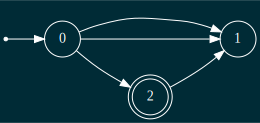

{9: 4, 17: 2, 33: 1, 65: 1, 129: 1, 10: 2, 18: 2, 34: 2, 66: 2, 130: 2, 12: 4, 20: 2, 36: 4, 68: 4, 132: 4}
+: {('blue', 'blue', 'red', 'blue', 'red')}
--------------
-: set()
17.058413927398163


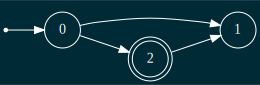

+: {('blue', 'blue', 'red', 'blue', 'red')}
--------------
-: {('blue', 'blue', 'blue', 'blue', 'blue', 'yellow', 'yellow')}
18.42402925221362


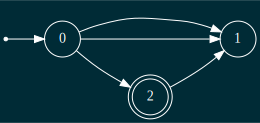

{17: 8, 33: 4, 65: 2, 129: 1, 257: 4, 18: 2, 34: 4, 66: 2, 130: 2, 258: 1, 20: 4, 36: 4, 68: 4, 132: 4, 260: 4, 24: 8, 40: 4, 72: 8, 136: 8, 264: 8}
+: {('blue', 'blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'red', 'blue', 'red')}
--------------
-: {('blue', 'blue', 'blue', 'blue', 'blue', 'yellow', 'yellow')}
12.884001555370293


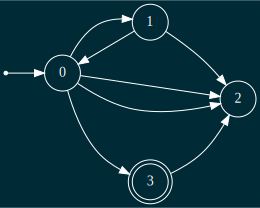

+: set()
--------------
-: {('blue', 'blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'red', 'blue', 'red')}
18.42402925221362


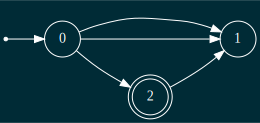

{17: 8, 33: 4, 65: 2, 129: 1, 257: 2, 18: 1, 34: 4, 66: 2, 130: 2, 258: 2, 20: 4, 36: 4, 68: 4, 132: 4, 260: 4, 24: 8, 40: 4, 72: 8, 136: 8, 264: 8}
+: {('blue', 'blue', 'blue', 'green', 'yellow', 'yellow')}
--------------
-: {('blue', 'blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'red', 'blue', 'red')}
18.213369325871824


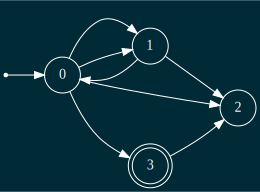

{17: 8, 33: 4, 65: 1, 129: 1, 257: 2, 18: 1, 34: 4, 66: 2, 130: 2, 258: 2, 20: 4, 36: 4, 68: 4, 132: 4, 260: 4, 24: 8, 40: 4, 72: 8, 136: 8, 264: 8}
+: {('blue', 'blue', 'blue', 'green', 'yellow', 'yellow')}
--------------
-: {('blue', 'blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'red', 'blue', 'red')}
18.424793635147147


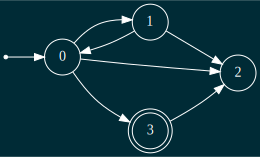

{17: 8, 33: 4, 65: 2, 129: 1, 257: 1, 18: 2, 34: 4, 66: 1, 130: 2, 258: 1, 20: 4, 36: 4, 68: 4, 132: 4, 260: 4, 24: 8, 40: 4, 72: 1, 136: 8, 264: 8}
+: {('blue', 'blue', 'blue', 'green', 'yellow', 'yellow')}
--------------
-: {('blue',
  'blue',
  'blue',
  'blue',
  'red',
  'red',
  'blue',
  'blue',
  'blue',
  'red',
  'yellow'),
 ('blue',
  'blue',
  'blue',
  'yellow',
  'yellow',
  'yellow',
  'yellow',
  'yellow',
  'yellow',
  'yellow'),
 ('blue', 'blue', 'red', 'blue', 'red'),
 ('blue', 'yellow'),
 ('green', 'yellow', 'blue')}
16.57171194376201


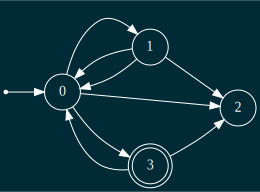

In [40]:
n_iters = 9

dfa_search = diss(
    demos=[to_demo(TRC4)],
    to_concept=to_concept2,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lambda x: lift_path(x),
    n_iters=n_iters,
    reset_period=4,
    surprise_weight=1,  # Rescale surprise to make comparable to size.
    cmf_threshold=0.99,
)

concept2energy2 = {}
for _, (data, concept, metadata) in zip(trange(n_iters, desc='DISS'), dfa_search):
    concept2energy2[concept] = metadata['energy']
    print(data)
    print(metadata['energy'])
    poi = metadata['poi']
    view_pydot(get_dot(concept.dfa))

Z=2.6731488281484344e-06
prob = 0.95
energy = 12.9
size = 0.847


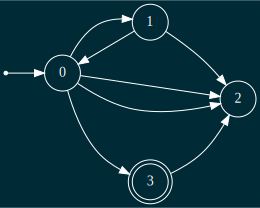

prob = 0.0238
energy = 16.6
size = 0.981


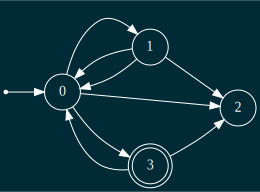

prob = 0.0146
energy = 17.1
size = 0.0


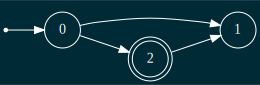

prob = 0.0046
energy = 18.2
size = 0.847


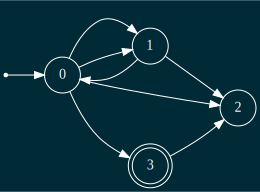

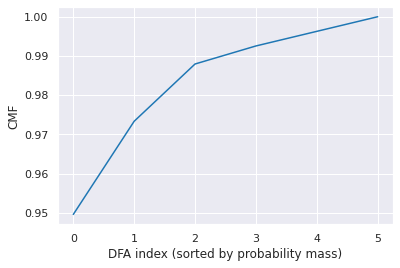

In [41]:
sorted_concepts = sorted(list(concept2energy2), key=concept2energy2.get)
pmf = np.array([np.exp(-concept2energy2[c]) for c in sorted_concepts])
Z = pmf.sum()
print(f'{Z=}')
pmf /= Z
cmf = np.cumsum(pmf)
idx = (cmf < 0.99).sum()  # 99% of probability mass concentrated below this point.

for p, c in zip(pmf, sorted_concepts[:idx + 1]):
    print(f'prob = {p:.3}')
    print(f'energy = {concept2energy2[c]:.3}')
    print(f'size = {c.size:.3}')
    view_pydot(get_dot(c.dfa))

# Plot CDF of distribution.
sns.lineplot(x=list(range(len(cmf))), y=cmf)
plt.xlabel('DFA index (sorted by probability mass)')
plt.ylabel('CMF')
plt.show()

In [42]:
# 4. Compute current support's belief on unlabeled strings of interest.
p_accept = {}
for word in poi:
    votes = np.array([(word in c) for c in sorted_concepts])
    p_accept[word] = pmf @ votes
    
sorted_poi = sorted(poi, key=lambda x: -p_accept[x])

buff = ''
for word in sorted_poi:
    obs = '\n'.join(map(tile, word))
    buff += f'{p_accept[word]:.2}:'.ljust(9, 'X').replace('X', '&nbsp')
    buff += f'{obs}<br>'
display(html_print(buff))

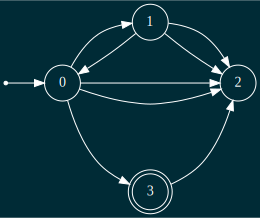

In [43]:
accepting, rejecting = set(), set()
for word in poi:
    belief = p_accept[word]
    if belief > 0.9:
        accepting.add(word)
    elif belief < 0.1:
        rejecting.add(word)
data = LabeledExamples(accepting, rejecting)
view_pydot(get_dot(to_concept(data).dfa))